### Ch3 Figure1

In [1]:
# What if their reports showed that customers are 2% more likely to click on a car if it's red. They could share that with car dealerships and generate new revenue.

# generate random data
data = []
n_records = 1000

# modified from http://adilmoujahid.com/posts/2014/07/twitter-analytics/

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#Variables that contains the user credentials to access Twitter API 
access_token = "your access_token"
access_token_secret = "your access_token_secret"
consumer_key = "your consumer_key"
consumer_secret = "your consumer_secret"

#This is a basic listener that just prints received tweets to stdout.
class StdOutListener(StreamListener):

    def on_data(self, data):
        
        # append new feed to .json file
        # press the square icon (interupt kernel) to stop
        with open('csv_output/ch3_fig1_twitter.json', 'a') as f:
            f.write(data)
        
        # print(data)
        return True

    def on_error(self, status):
        print(status)

#This handles Twitter authetification and the connection to Twitter Streaming API
l = StdOutListener()
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
stream = Stream(auth, l)

#This line filter Twitter Streams to capture data by the keywords: 'python', 'javascript', 'ruby'
stream.filter(track=['shoe', 'travel', 'eating'])

In [2]:
# read twitter data
import json

tweets_data = []
tweets_file = open('csv_output/ch3_fig1_twitter.json', "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

df = pd.DataFrame()
df['text'] = list(map(lambda x: x['text'], tweets_data))
df['country'] = list(map(lambda x: x['place']['country'] if x['place'] != None else None, tweets_data))

In [4]:
# example of unstructured data
# > tweet
# {'contributors': None,
#  'coordinates': None,
#  'created_at': 'Fri Jun 24 19:39:56 +0000 2016',
#  'entities': {'hashtags': [{'indices': [65, 73], 'text': 'Memphis'},
#    {'indices': [94, 101], 'text': 'Travel'},
#    {'indices': [102, 112], 'text': 'Tennessee'},
#    {'indices': [113, 122], 'text': 'MadeInTN'},
#    {'indices': [123, 130], 'text': 'Foodie'}],
#   'media': [{'display_url': 'pic.twitter.com/RTwtW9Auos',
#     'expanded_url': 'http://twitter.com/MrScottEddy/status/746395633381081089/photo/1',
#     'id': 746395574115540996,
#     'id_str': '746395574115540996',
#     'indices': [139, 140],
#     'media_url': 'http://pbs.twimg.com/media/Clu60fEUoAQryaW.jpg',
#     'media_url_https': 'https://pbs.twimg.com/media/Clu60fEUoAQryaW.jpg',
#     'sizes': {'large': {'h': 768, 'resize': 'fit', 'w': 1024},
#      'medium': {'h': 768, 'resize': 'fit', 'w': 1024},
#      'small': {'h': 510, 'resize': 'fit', 'w': 680},
#      'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
#     'source_status_id': 746395633381081089,
#     'source_status_id_str': '746395633381081089',
#     'source_user_id': 22411342,
#     'source_user_id_str': '22411342',
#     'type': 'photo',
#     'url': 'https://t.co/RTwtW9Auos'}],
#   'symbols': [],
#   'urls': [],
#   'user_mentions': [{'id': 22411342,
#     'id_str': '22411342',
#     'indices': [3, 15],
#     'name': 'Scott Eddy ✈',
#     'screen_name': 'MrScottEddy'},
# ...

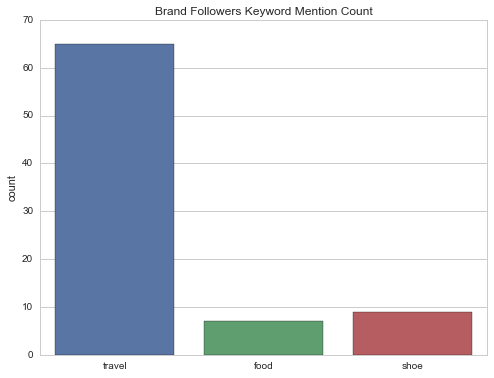

In [3]:
%matplotlib inline
sns.set_style("whitegrid")

drawdf = pd.DataFrame([df[df['text'].str.contains('travel')].count().values[0],
                       df[df['text'].str.contains('food')].count().values[0],
                       df[df['text'].str.contains('shoe')].count().values[0]],
                       index=['travel', 'food', 'shoe'], columns=['count'])
f, ax = plt.subplots(1,1, figsize=(8,6))
sns.barplot(y=drawdf['count'],x=['travel', 'food', 'shoe'], ax=ax);
ax.set_title('Brand Followers Keyword Mention Count'); ax.set_ylabel('count');

f.savefig('svg_output/ch3_fig1.svg', format='svg')

In [4]:
%load_ext rpy2.ipython

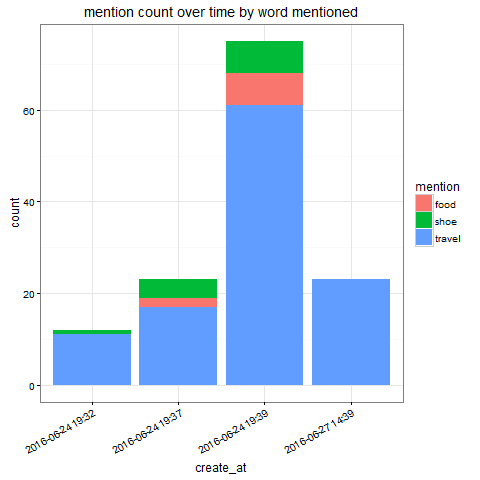

In [5]:
%%R
require(jsonlite)
require(dplyr)

df <- stream_in(file('csv_output/ch3_fig1_twitter.json'))
df$create_at_timestamp = strptime(df[,1], "%a %b %d %H:%M:%S +0000 %Y")
df$has_travel = grepl('travel', df$text, ignore.case=TRUE)
df$has_food = grepl('food', df$text, ignore.case=TRUE)
df$has_shoe= grepl('shoe', df$text, ignore.case=TRUE)

r1 <- aggregate(df$has_travel,
                by=list(format(df$create_at_timestamp, "%Y-%m-%d %H:%M")),
                sum)
r2 <- aggregate(df$has_food,
                by=list(format(df$create_at_timestamp, "%Y-%m-%d %H:%M")),
                sum)
r3 <- aggregate(df$has_shoe,
                by=list(format(df$create_at_timestamp, "%Y-%m-%d %H:%M")),
                sum)
colnames(r1) = c('create_at', 'count')
r1$mention='travel'
colnames(r2) = c('create_at', 'count')
r2$mention='food'
colnames(r3) = c('create_at', 'count')
r3$mention='shoe'
df2=bind_rows(r1,r2,r3)

require(ggplot2)
ggplot(df2, aes(x=create_at, y=count, fill=mention)) + geom_bar(stat = "identity") + ggtitle('mention count over time by word mentioned') + theme_bw()  + theme(axis.text.x = element_text(angle = 30, hjust= 1))
# ggsave("svg_output/ch3_fig1_R.svg")